# Federated Learning with Flower

#### This notebook presents a simple Federated Learning example / application on developing a Machine Learning model as an Intrusion Detection System for defending against Cyberattacks using distributed and private data.
#### This example uses Docker containers as independent workers / clients for performing the client model training on the limited and private local client data.
#### This example was developed as part of the research conducted at MetaMind Innovations in the framework of the [AI4CYBER](http://metamind.gr/portfolio-items/ai4cyber-horizon-europe/) project.

### This notebook, as well as the Flower example, were implemented and tested using Python v3.11, Flower v1.5 and TensorFlow v2.14.1

## Set Up Flower Environment

In [1]:
# !pip install --quiet --upgrade flwr==1.5.0
# !pip install --quiet --upgrade tensorflow-cpu==2.14.1
# !pip install --quiet --upgrade scikit-learn
# !pip install --quiet --upgrade pandas
# !pip install --quiet --upgrade matplotlib
# !pip install --quiet --upgrade git+https://github.com/nepiskopos/py7zr.git

## Dataset

This dataset is part of the [IEC 60870-5-104 Intrusion Detection Dataset](http://ieee-dataport.org/documents/iec-60870-5-104-intrusion-detection-dataset) -- DOI: [10.1109/TII.2021.3093905](http://doi.org/10.1109/TII.2021.3093905) -- published by [ITHACA – University of Western Macedonia](http://ithaca.ece.uowm.gr/).

In [2]:
import errno
import os
import py7zr
import re
import shutil
import sys
import time
import urllib


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

def download(url, filename):
    urllib.request.urlretrieve(url, filename, reporthook)

def extract(archive, target_dir):
    archive = py7zr.SevenZipFile(archive, mode='r')
    try:
        os.makedirs(target_dir)
        
        archive.extractall(path=target_dir)
        archive.close()
        
        print(f"Archive '{archive}' extracted successfully!")
    except OSError as e:
        if e.errno == errno.EEXIST:
            archive.extractall(path=target_dir)
            archive.close()
            
            print(f"Archive '{archive}' extracted successfully!")
        else:
            print(f"Archive '{archive}' failed to extract...")


base_data_dir = './datasets'

if not os.path.isdir(os.path.join(base_data_dir, 'Balanced_IEC104_Train_Test_CSV_Files')):
    filename = 'Balanced_IEC104_Train_Test_CSV_Files.7z'
    
    if not py7zr.is_7zfile(filename):
        url = ('https://zenodo.org/records/7108614/files/Balanced_IEC104_Train_Test_CSV_Files.7z?download=1')
        download(url, filename)
    
    extract(filename, base_data_dir)
    
    os.remove(os.path.join('.', filename))

In [3]:
import collections
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

%matplotlib inline

We input the dataset path and choose which dataset to facilitate for the experimentation.

For this example we use the CICFlowMeter dataset with capturing timeout at 180 seconds with 3 distinct workers.

In [4]:
tp = 'cic'      # Type: dataset type (CICFlowMeter or Custom Python parser), choose between 'cic' and 'custom'
tm = 180        # Timeout: data flow timeout, choose a value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 3   # N: number of federated workers, choose between 3 and 5

Perform some value checks

In [5]:
assert tp in ('cic', 'custom'), "Wrong dataset type, choose between 'cic' and 'custom'"
assert tm in (15, 30, 60, 90, 120, 180), "Wrong time, choose a value from the following list [15, 30, 60, 90, 120, 180]"
assert n_workers in (3, 4, 5), "Wrong number of workers, choose between 3 and 5"

In [6]:
path = os.path.join(base_data_dir, 'Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs')
dataset = f'tests_{tp}_{tm}'

if 'cic' in dataset:
    n = dataset.split('_')[-1]
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_cicflow.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_cicflow.csv')
elif 'custom' in dataset:
    n = dataset.split('_')
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_custom_script.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_custom_script.csv')
else:
    raise Exception("Wrong dataset")

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(train_csv)

Let's perform some data exploration.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

As a preprocessing step, we transorm the "Label" feature from string to categorical and then to numeric.

In [9]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())

mapping = dict(zip(unique_labels, unique_codes))
mapping_inv = dict(zip(unique_codes, unique_labels))

In [10]:
df_train['Label'] = df_train['Label'].astype('category').cat.rename_categories(mapping)
df_test['Label'] = df_test['Label'].astype('category').cat.rename_categories(mapping)

Now, we remove the features which can not contribute in training a ML model.

In [11]:
if tp == 'cic':
    train = df_train.iloc[:,7:]
    test = df_test.iloc[:,7:]
else:
    train = df_train
    test = df_test

We rename the "Label" column to "y".

In [12]:
train.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.rename(columns={"Label": "y"}, inplace=True, errors="raise")

We drop Inf and NaN values both in the training and in test feature data.

In [13]:
# Replace Inf values with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
train.dropna(inplace=True)
test.dropna(inplace=True)

We store the modified datasets into new local CSV files for future use and model evaluation.

In [14]:
directory = os.path.join(base_data_dir, 'federated_datasets')

try:
    os.makedirs(directory)
    train.to_csv(os.path.join(directory, 'train_data.csv'), index=False)
    test.to_csv(os.path.join(directory, 'test_data.csv'), index=False)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In this example, we use $N=3$ individual workers.

Each worker will be assigned a subset of the dataset with $\lfloor {M \over N} \rfloor$ data points.

In [15]:
n_samples = int(train.shape[0] / n_workers)

assert type(n_workers) == int, "Non-int number of workers"
assert n_workers >= 3 and n_workers <= df_train.shape[0], "At least 3 workers and at most as many workers as the number of samples are allowed"
assert n_samples > 0, "Each worker must be assigned at least one data point"

Each worker's training data is stored as a seperate CSV file with the proper naming and data format schemes.

In [16]:
client_data = []
train_copy = train.copy()

for i in range(n_workers):
    sample = train_copy.sample(n=n_samples)
    sample.to_csv(os.path.join(directory, f'client_train_data_{i+1}.csv'), index=False)
    train_copy.drop(index=sample.index, inplace=True)
    client_data.append(sample)

Let's check the number of points in each straggler's training data.

In [17]:
for i in range(n_workers):
    print(f"Worker {i+1} training data contains {len(client_data[i])} points")

Worker 1 training data contains 1196 points
Worker 2 training data contains 1196 points
Worker 3 training data contains 1196 points


Let's perform some statistical analysis on the difference in the number of samples for each digit in each client dataset.

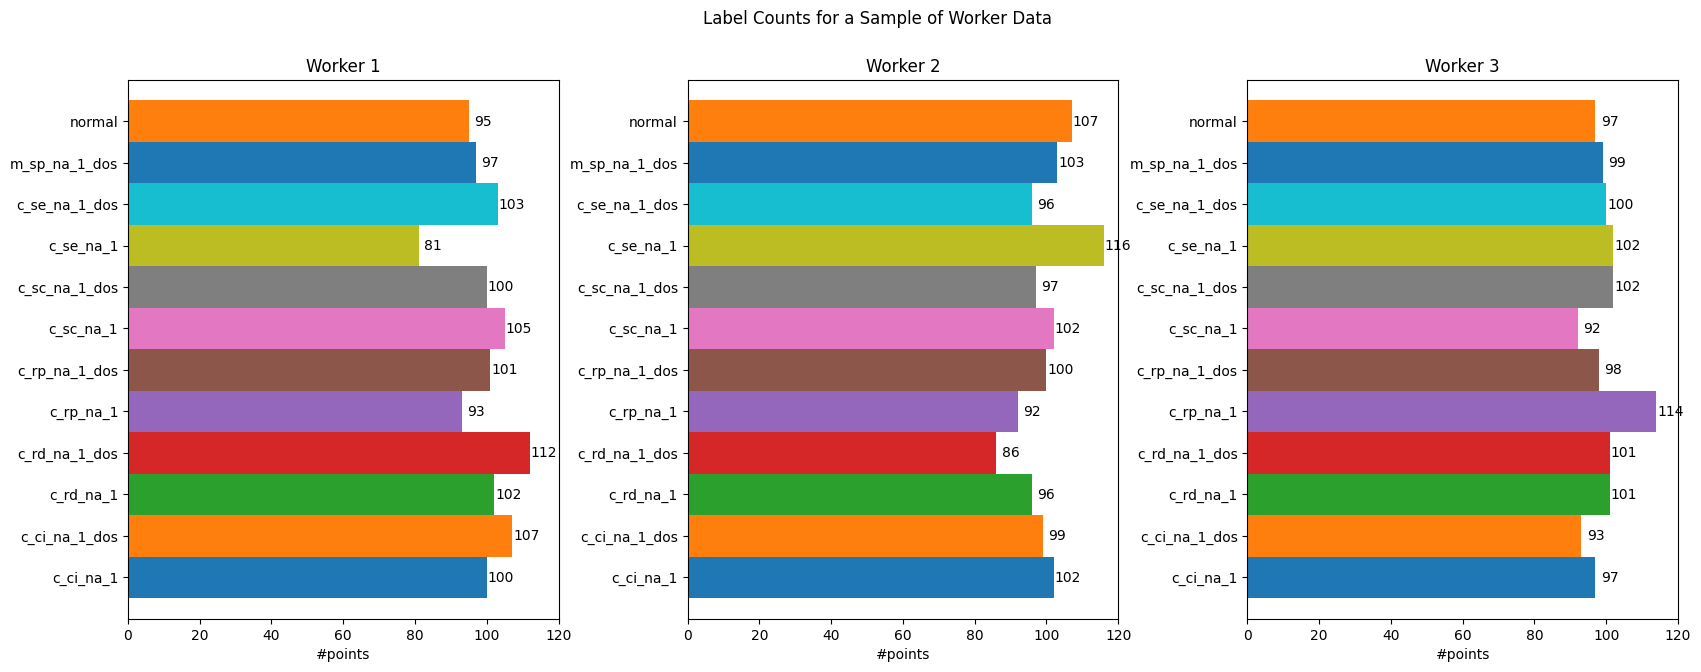

In [18]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    sample = client_data[i]
    for label in sample['y']:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(20-m%20)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping_inv[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    # plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+4, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

### Launch $N=3$ Flower FL workers as Docker Containers locally using the **docker-compose.yaml**

```
docker-compose -f ./docker-compose.yaml up --scale flwr_c=3
```

## Centralized model

Let's train a centralized IDS model to use as a baseline model for evaluation reference.

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

2024-04-29 13:49:56.918151: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:49:56.939522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We have to scale the data to avoid huge value deviations.

In [20]:
scaler = MinMaxScaler()

In [21]:
X_train_scaled = scaler.fit_transform(train.drop(['y'], axis=1).to_numpy())
y_train = train['y'].to_numpy()
X_test_scaled = scaler.transform(test.drop(['y'], axis=1).to_numpy())
y_test = test['y'].to_numpy()

Then, we are better off using one-hot-vectors than scalars for the label representation.

In [22]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

We define a MLP model with one hidden layer.

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=y_train_cat.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We use early stopping monitoring the validation loss to avoid overfitting.

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

Let's train the model.

In [25]:
model.fit(
    x=X_train_scaled, 
    y=y_train_cat, 
    epochs=300,
    validation_data=(X_test_scaled, y_test_cat),
    verbose=1,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/300
57/57 [==============================] - 0s 4ms/step - loss: 2.3098 - accuracy: 0.2143 - val_loss: 2.1409 - val_accuracy: 0.2561
Epoch 2/300
57/57 [==============================] - 0s 2ms/step - loss: 2.0734 - accuracy: 0.2625 - val_loss: 2.0018 - val_accuracy: 0.2949
Epoch 3/300
57/57 [==============================] - 0s 2ms/step - loss: 1.9773 - accuracy: 0.2910 - val_loss: 1.9272 - val_accuracy: 0.3534
Epoch 4/300
57/57 [==============================] - 0s 3ms/step - loss: 1.9226 - accuracy: 0.2954 - val_loss: 1.8812 - val_accuracy: 0.3576
Epoch 5/300
57/57 [==============================] - 0s 2ms/step - loss: 1.8835 - accuracy: 0.3172 - val_loss: 1.8483 - val_accuracy: 0.3403
Epoch 6/300
57/57 [==============================] - 0s 2ms/step - loss: 1.8513 - accuracy: 0.3255 - val_loss: 1.8185 - val_accuracy: 0.3746
Epoch 7/300
57/57 [==============================] - 0s 2ms/step - loss: 1.8267 - accuracy: 0.3188 - val_loss: 1.7922 - val_accuracy: 0.3548
Epoch 8/300
5

Let's plot the Loss vs Epoch chart.

<Axes: >

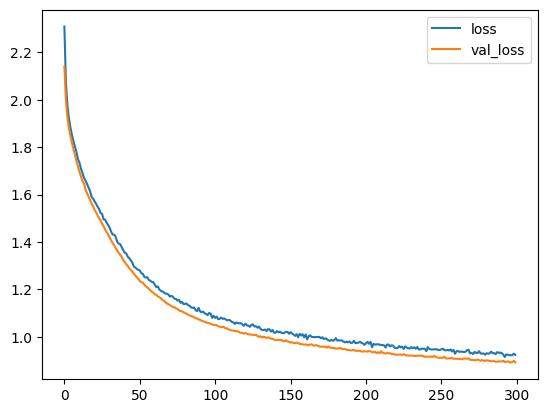

In [26]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss','val_loss']].plot()

Let's evaluate the trained model.

In [27]:
print("Loss, Accuracy: ", model.evaluate(X_test_scaled, y_test_cat))

113/113 [==============================] - 0s 1ms/step - loss: 0.8919 - accuracy: 0.5686
Loss, Accuracy:  [0.8918614387512207, 0.568561851978302]


In [28]:
print("F1-score: ", f1_score(y_test, np.argmax(model.predict(X_test_scaled), axis=1), average='weighted'))

113/113 [==============================] - 0s 1ms/step
F1-score:  0.5479374671866031


With a simple, unoptimized NN model a F1-score of approximately 54% was achieved.

There is always room for model fine-tuning, optimizations and futher model improvements.